In [46]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import nltk

In [47]:
def pipeline(news_source):
    client = MongoClient()
    db = client[f'{news_source}']
    articles = db['articles']
    df = pd.DataFrame(list(articles.find()))
    df = df.iloc[:,1:]
    df['title']=[title.strip() for title in df['title']]
    df = df.drop_duplicates()
    df['source']=f'{news_source}'
    df.reset_index(inplace=True)
    df = df.iloc[:,1:]
    new_content=[]
    for article in df['content']:
        sentences = article.split(".")
        if sentences[-1].startswith('com')==True:
            sentences = sentences[:-2]
            new_content.append(".".join(sentences))
        else:
            sentences = sentences[:-1]
            new_content.append(".".join(sentences))
    df['content']= new_content
    
            
    return df

In [6]:
fox_news = pipeline('fox')

In [48]:
articles = pd.concat([pipeline('occupy_democrats'),pipeline('breitbart')])

In [57]:
def plot_word_counts():
    def get_word_count(article):
        return len(article.split())
    word_count_oc=[]
    word_count_breit= []
    for idx,article in enumerate(articles['content']):
        if articles['source'].iloc[idx]=='occupy_democrats':
            word_count_oc.append(get_word_count(article))
        else:
            word_count_breit.append(get_word_count(article))
    
    fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
    ax[0].hist(word_count_oc,color="b",label="Occupy Democrats")
    ax[1].hist(word_count_breit,label="Breitbart")
    ax[0].set_xlabel("Word Count")
    ax[0].set_ylabel("Frequency")
    ax[1].set_xlabel("Word Count")
    plt.suptitle("Word Counts for each Website")
    fig.legend();

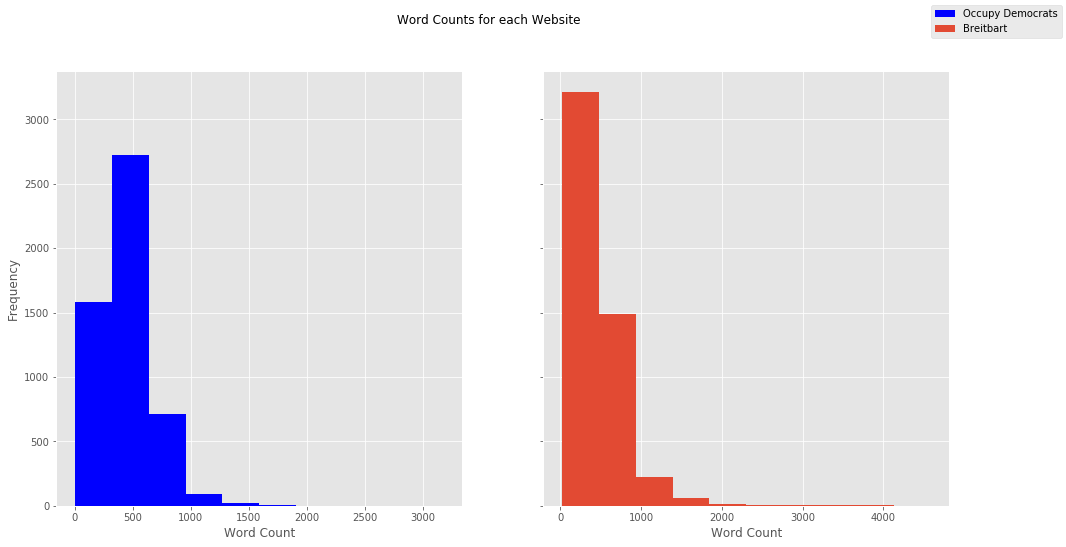

In [58]:
plot_word_counts()

author            source   
Charlie Spiering  breitbart    434
Hannah Bleau      breitbart    393
Pam Key           breitbart    313
Joshua Caplan     breitbart    308
Ian Hanchett      breitbart    232
Joel B. Pollak    breitbart    192
John Binder       breitbart    186
Trent Baker       breitbart    158
AWR Hawkins       breitbart    146
Penny Starr       breitbart    146
Name: title, dtype: int64


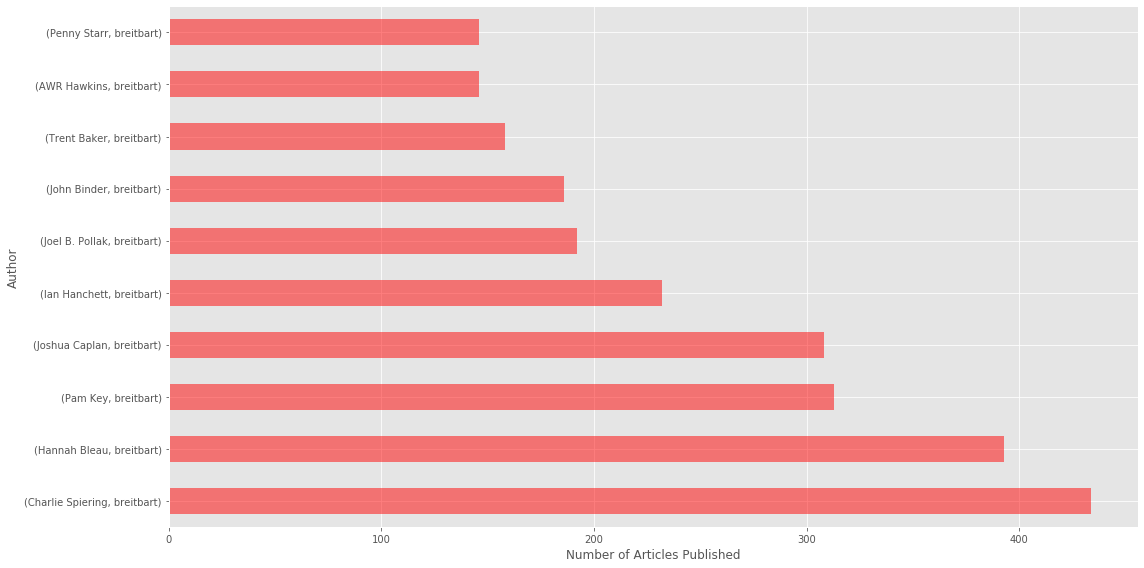

In [10]:
breitbart_top_ten = articles[articles['source']=='breitbart'].groupby(['author','source']).count().sort_values('date',ascending=False)['title'].iloc[0:10]
print(breitbart_top_ten)
fig,ax=plt.subplots(figsize=(16,8))
breitbart_top_ten.plot(kind='barh',color="r",alpha=0.5)
ax.set_ylabel("Author")
ax.set_xlabel("Number of Articles Published")
plt.tight_layout();

author             source          
Colin Taylor       occupy_democrats    920
Natalie Dickinson  occupy_democrats    768
Vinnie Longobardo  occupy_democrats    633
Grant Stern        occupy_democrats    515
Brian Tyler Cohen  occupy_democrats    438
Sheila Norton      occupy_democrats    371
Rob Haffey         occupy_democrats    361
Marisa Manfredo    occupy_democrats    245
Peter Mellado      occupy_democrats    194
Benjamin Locke     occupy_democrats    189
Name: title, dtype: int64


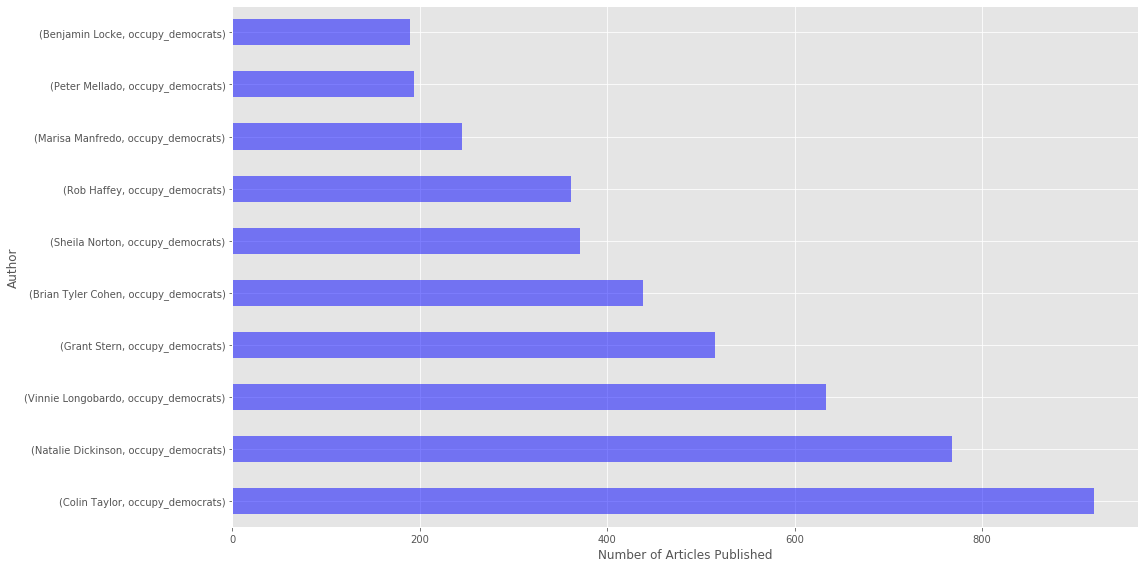

In [11]:
occupy_top_ten = articles[articles['source']=='occupy_democrats'].groupby(['author','source']).count().sort_values('date',ascending=False)['title'].iloc[0:10]
print(occupy_top_ten)
fig,ax=plt.subplots(figsize=(16,8))
occupy_top_ten.plot(kind='barh',color="b",alpha=0.5)
ax.set_ylabel("Author")
ax.set_xlabel("Number of Articles Published")
plt.tight_layout();

In [12]:
articles['date'] = pd.to_datetime(articles['date'])
date_counts = articles.sort_values('date').groupby('date').count()
date_counts

title  author  content  source
date                                      
2013-04-19      1       1        1       1
2013-04-20      1       1        1       1
2013-04-21      1       1        1       1
2013-04-22      2       2        2       2
2016-05-09      4       4        4       4
...           ...     ...      ...     ...
2020-05-03     55      55       55      55
2020-05-04     92      92       92      92
2020-05-05     99      99       99      99
2020-05-06    109     109      109     109
2020-05-07     47      47       47      47

[717 rows x 4 columns]

In [45]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('breitbart')
stopwords.append('follow')
stopwords.append('facebook')
stopwords.append('twitter')
stopwords.append('email')
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,stop_words=stopwords,max_features=500)
tfidf = vectorizer.fit_transform(articles['content'])
X_train, X_test, y_train, y_test = train_test_split(tfidf, articles['source'],test_size=0.2, random_state=0)

In [46]:
model1 = MultinomialNB(0.1)
model1.fit(X_train,y_train)
model1.score(X_test,y_test)

0.9084645669291339

In [47]:
model2 = RandomForestClassifier(n_estimators=60)
model2.fit(X_train, y_train)
model2.score(X_test,y_test)

0.9517716535433071

In [16]:
def test_bias(text,model):
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english',max_features=500)
    X = vectorizer.fit_transform(text)
    yhat= model.predict_proba(X)
    breit = [i[0] for i in yhat]
    occ = [i[1] for i in yhat]
    yhat2 = model.predict(X)
    count=0
    for pred in yhat2:
        if pred=='breitbart':
            count+=1
    breit_freq = (count/31)*100
    return f'Breitbart: {round(np.mean(breit)*100,2)}%, Occupy Democrats : {round(np.mean(occ)*100,2)}%. Predicted as Breitbart {round(breit_freq,2)}% of the time.'




In [17]:
reuters = pipeline('reuters')

In [48]:
test_bias(fox_news['content'],model2)

'Breitbart: 60.65%, Occupy Democrats : 39.35%. Predicted as Breitbart 87.1% of the time.'

In [49]:
test_bias(reuters['content'],model2)

'Breitbart: 59.67%, Occupy Democrats : 40.33%. Predicted as Breitbart 54.84% of the time.'

In [20]:
def get_most_important_words(model,num_of_words):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    feature_names = vectorizer.get_feature_names()
    top_words = []

    for i in range(num_of_words):
        top_words.append(feature_names[indices[i]])
    return top_words

In [50]:
get_most_important_words(model2,30)

['trump',
 'coronavirus',
 'said',
 '2020',
 'added',
 'pandemic',
 'republican',
 'name',
 '2017',
 'virus',
 'tuesday',
 'democrat',
 'add',
 'donald',
 'biden',
 'president',
 'wednesday',
 'republicans',
 'china',
 'monday',
 'news',
 'thursday',
 'covid',
 'health',
 'sunday',
 'sanders',
 'today',
 'friday',
 'russian',
 'white']

In [49]:
test1,test2 = articles['content'].iloc[9303],articles['content'].iloc[9304]

In [50]:
test1

'Israel provides the most protections for LGBT people in the Middle East. And yet, more than 100 LGBT filmmakers have signed a pledge to boycott\xa0Tel Aviv’s government-sponsored LGBT film festival, TLVFest, in what they claim is a show of solidarity towards members of the Palestinian LGBT community. The Hollywood Reporter\xa0reports that the boycott was organized by Palestinian queer organizations and PACBI, the academic and cultural arm of the Boycott Divestment Sanctions (BDS) movement that seeks to compel the world to cut all ties with Israel in protest of a so-called occupation. Signatories include the Turner Prize winner Charlotte Prodger, Palme d’Or nominee Alain Guiraudie, and award-winning Indian documentary filmmaker Harjant Gill, among others. The pledge claims that the LGBT movement\xa0“is intimately connected to the liberation of all oppressed peoples and communities” and commits “not to submit films or otherwise participate in TLVFest or other events partially or fully s

In [51]:
test2

'Following Democratic presidential hopeful Pete Buttigieg’s announcement that he was dropping out of the race, Silicon Valley leaders are reportedly begging Democrats to nominate anyone but Bernie Sanders. The\xa0New York Times writes in an article titled “Silicon Valley Leaders’ Plea to Democrats: Anyone but Sanders,” that\xa0following the departure of Silicon Valley’s preferred candidate from the Democratic presidential nomination race, Silicon Valley leaders are panicking. Pete Buttigieg was heavily favored by many in Silicon Valley as explained by Breitbart Tech senior reporter Allum Bokhari, but after the candidate dropped out this week, tech executives had just one request of the Democrats: “nominate anyone except Bernie Sanders, please.” The\xa0NYT\xa0writes: The Silicon Valley venture capitalist Keith Rabois, onstage in January at a tech conference, said his first choice for president was a Democrat, Pete Buttigieg. And, sure, it would be a close call for Joseph R. Biden Jr. ov

In [52]:
test = [test1,test2]
new_content=[]
for article in test:
    sentences = article.split(".")
    if sentences[-1].startswith('com')==True:
        sentences = sentences[:-2]
        new_content.append(".".join(sentences))
    else:
        sentences = sentences[:-1]
        new_content.append(".".join(sentences))


In [54]:
new_content[0]

'Israel provides the most protections for LGBT people in the Middle East. And yet, more than 100 LGBT filmmakers have signed a pledge to boycott\xa0Tel Aviv’s government-sponsored LGBT film festival, TLVFest, in what they claim is a show of solidarity towards members of the Palestinian LGBT community. The Hollywood Reporter\xa0reports that the boycott was organized by Palestinian queer organizations and PACBI, the academic and cultural arm of the Boycott Divestment Sanctions (BDS) movement that seeks to compel the world to cut all ties with Israel in protest of a so-called occupation. Signatories include the Turner Prize winner Charlotte Prodger, Palme d’Or nominee Alain Guiraudie, and award-winning Indian documentary filmmaker Harjant Gill, among others. The pledge claims that the LGBT movement\xa0“is intimately connected to the liberation of all oppressed peoples and communities” and commits “not to submit films or otherwise participate in TLVFest or other events partially or fully s